In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

# Retrieve Data:
    SF Restaurants Health Inspections by Department of Public Health

In [2]:
!rm SFFoodProgram_Complete_Data.zip
!rm violations_plus.csv
!rm businesses_plus.csv
!rm inspections_plus.csv
!wget -qO- -O tmp.zip https://extxfer.sfdph.org/food/SFFoodProgram_Complete_Data.zip && unzip tmp.zip && rm tmp.zip

rm: SFFoodProgram_Complete_Data.zip: No such file or directory
Archive:  tmp.zip
  inflating: violations_plus.csv     
  inflating: businesses_plus.csv     
  inflating: inspections_plus.csv    


# Inspections

In [3]:
df_inspec = pd.read_csv('inspections_plus.csv')
print str(df_inspec.shape[0]) + ' records in inspections file'
print str(len(np.unique(df_inspec.business_id))) + ' unique business_id in inspections file'
print list(df_inspec.columns)
print df_inspec.head(5)
print np.unique(df_inspec[(df_inspec['type']=='Reinspection/Followup')].Score)
print
print str(df_inspec[(df_inspec.Score.notnull())].shape[0]) + ' records with non-null score in inspections file'
df_inspec = df_inspec[(df_inspec.Score.notnull())]
print str(len(np.unique(df_inspec.business_id))) + ' unique business_id in inspections file with non-null score'
print

print df_inspec.head()
df_inspec = df_inspec.sort(['date'], ascending=False).groupby('business_id', as_index=False).first()
print
print str(df_inspec.shape[0]) + ' records in inspections file rolled-up on business_id with non-null score'
df_inspec.columns = ['business_id','score','inspection_date','type']
df_inspec.head()

29486 records in inspections file
5951 unique business_id in inspections file
['business_id', 'Score', 'date', 'type']
   business_id  Score      date                   type
0           10    NaN  20140807  Reinspection/Followup
1           10     94  20140729  Routine - Unscheduled
2           10    NaN  20140124  Reinspection/Followup
3           10     92  20140114  Routine - Unscheduled
4           17    NaN  20140425  Reinspection/Followup
[ 85.  nan  nan ...,  nan  nan  nan]

16606 records with non-null score in inspections file
5525 unique business_id in inspections file with non-null score

   business_id  Score      date                   type
1           10     94  20140729  Routine - Unscheduled
3           10     92  20140114  Routine - Unscheduled
5           17     94  20140312  Routine - Unscheduled
7           17     94  20130605  Routine - Unscheduled
8           19     94  20141110  Routine - Unscheduled

5525 records in inspections file rolled-up on business_id with 

,business_id,score,inspection_date,type
0,10,94,20140729,Routine - Unscheduled
1,17,94,20140312,Routine - Unscheduled
2,19,94,20141110,Routine - Unscheduled
3,24,96,20141124,Routine - Unscheduled
4,31,100,20140908,Routine - Unscheduled


# Violations

In [4]:
df_violn = pd.read_csv('violations_plus.csv')
df_violn = df_violn.fillna('NULL')
print list(df_violn.columns)

print str(df_violn.shape[0]) + ' records in violations file'
print str(len(np.unique(df_violn.business_id))) + ' unique business_id in violations file'
print df_violn.head()

print
df_viol = pd.DataFrame(df_violn.groupby(['business_id','date']).apply(lambda x: 
                zip(list(x.ViolationTypeID),list(x.risk_category),list(x.description))),
                columns = ['list_of_tuples_violationTypeID_riskCategory_description']).reset_index()
print df_viol.head()

print
df_viol = df_viol.sort(['date'], ascending=False).groupby('business_id', as_index=False).first()
df_viol.columns = ['business_id','violation_date','list_of_tuples_violationTypeID_riskCategory_description']
df_viol.head()

['business_id', 'date', 'ViolationTypeID', 'risk_category', 'description']
42459 records in violations file
5073 unique business_id in violations file
   business_id      date  ViolationTypeID  risk_category  \
0           10  20140114           103119  Moderate Risk   
1           10  20140114           103145       Low Risk   
2           10  20140114           103154       Low Risk   
3           10  20140729           103144       Low Risk   
4           10  20140729           103129  Moderate Risk   

                                         description  
0  Inadequate and inaccessible handwashing facili...  
1   Improper storage of equipment utensils or linens  
2       Unclean or degraded floors walls or ceilings  
3   Unapproved or unmaintained equipment or utensils  
4            Insufficient hot water or running water  

   business_id      date  \
0           10  20140114   
1           10  20140729   
2           17  20130605   
3           17  20140312   
4           19  2

,business_id,violation_date,list_of_tuples_violationTypeID_riskCategory_description
0,10,20140729,"[(103144, Low Risk, Unapproved or unmaintained..."
1,17,20140312,"[(103154, Low Risk, Unclean or degraded floors..."
2,19,20141110,"[(103116, Moderate Risk, Inadequate food safet..."
3,24,20141124,"[(103119, Moderate Risk, Inadequate and inacce..."
4,45,20140909,"[(103149, Low Risk, Wiping cloths not clean or..."


# Businesses

In [5]:
def clean_postal_code(postal_code):
    if str(postal_code) == 'nan' or str(postal_code)[0] != '9':
        return np.nan
    else:
        x_len = len(postal_code)
        if x_len == 5 and postal_code.isdigit():
            return postal_code
        else:
            postal_code_cleaned = [d for d in postal_code if d.isdigit()]
            if len(postal_code_cleaned) > 5:
                postal_code_cleaned = postal_code_cleaned[:5]
                return ''.join(postal_code_cleaned)
            elif len(postal_code_cleaned) == 5:
                return ''.join(postal_code_cleaned)
            else: return np.nan

In [6]:
df_bus = pd.read_csv('businesses_plus.csv')
print list(df_bus.columns)

print str(df_bus.shape[0]) + ' records in business file'
print str(len(np.unique(df_bus.business_id))) + ' unique business_id in business file'
df_byBusinessID = pd.DataFrame(df_bus.groupby('business_id').apply(lambda x: np.size(x.business_id)),
                               columns=['Frequency'])
print df_byBusinessID[(df_byBusinessID.Frequency>1)]
multi_record_bus = list(df_byBusinessID[(df_byBusinessID.Frequency>1)].index)
print multi_record_bus
print
for bid in multi_record_bus:
    print df_bus[(df_bus.business_id==bid)][['business_id','owner_name','latitude','longitude']]
    print

df_bus = df_bus.reset_index()
df_bus = df_bus.sort(['index'], ascending=False).groupby('business_id', as_index=False).first()


print str(df_bus.shape[0]) + ' unique records in new business dataframe rolled-up on business id'
print
print df_bus[(df_bus.business_id==3543)][['business_id','owner_name']]

print
print "Unique postal codes:"
postal_codes = list(np.unique(df_bus[(df_bus.postal_code.notnull())].postal_code))
print postal_codes

print
print "Clean Postal Codes"
df_bus['postal_code'] = df_bus.apply(lambda x: clean_postal_code(x.postal_code), axis=1)
postal_codes = list(np.unique(df_bus[(df_bus.postal_code.notnull())].postal_code))
print postal_codes

['business_id', 'name', 'address', 'city', 'postal_code', 'latitude', 'longitude', 'phone_number', 'TaxCode', 'business_certificate', 'application_date', 'owner_name', 'owner_address', 'owner_city', 'owner_state', 'owner_zip']
7608 records in business file
7591 unique business_id in business file
             Frequency
business_id           
3543                 2
3566                 2
5301                 2
5830                 2
9463                 2
33467                2
62053                2
62797                2
66698                4
68390                2
75407                2
80680                2
80829                2
81516                2
84527                2
[3543, 3566, 5301, 5830, 9463, 33467, 62053, 62797, 66698, 68390, 75407, 80680, 80829, 81516, 84527]

      business_id               owner_name   latitude   longitude
1066         3543       Lamps of China Inc  37.795288 -122.405543
1067         3543  Fortune Family Six, Inc  37.795288 -122.405543

      busi

# Merge dataframes: Businesses, Inspections, Violations

In [7]:
print str(df_bus.shape[0]) + ' records in business data'
print str(df_viol.shape[0]) + ' records in violations data'
print str(df_inspec.shape[0]) + ' records in inspections data'
print
df = pd.merge(df_bus,df_viol,on='business_id',how='inner')
df.drop('index', axis=1, inplace=True)
print str(df.shape[0]) + ' records in inner merge of business and violations data'
df = pd.merge(df,df_inspec,on='business_id',how='inner')
df.set_index('business_id').to_csv('bus_viol_inspec.csv')
print str(df.shape[0]) + ' records in inner merge of business, violations and inspections data'
print
df.head()

7591 records in business data
5073 records in violations data
5525 records in inspections data

5059 records in inner merge of business and violations data
5034 records in inner merge of business, violations and inspections data



,business_id,name,address,city,postal_code,latitude,longitude,phone_number,TaxCode,business_certificate,...,owner_name,owner_address,owner_city,owner_state,owner_zip,violation_date,list_of_tuples_violationTypeID_riskCategory_description,score,inspection_date,type
0,10,Tiramisu Kitchen,033 Belden Pl,San Francisco,94104,37.791116,-122.403816,NaN,H24,779059,...,Tiramisu LLC,33 Belden St,San Francisco,CA,94104,20140729,"[(103144, Low Risk, Unapproved or unmaintained...",94,20140729,Routine - Unscheduled
1,17,GEORGE'S COFFEE SHOP,2200 OAKDALE Ave,S.F.,94124,37.741086,-122.401737,14155531470,H24,78443,...,"LIEUW, VICTOR & CHRISTINA C",648 MACARTHUR DRIVE,DALY CITY,CA,94015,20140312,"[(103154, Low Risk, Unclean or degraded floors...",94,20140312,Routine - Unscheduled
2,19,Nrgize Lifestyle Cafe,"1200 Van Ness Ave, 3rd Floor",San Francisco,94109,37.786848,-122.421547,NaN,H24,NaN,...,24 Hour Fitness Inc,"1200 Van Ness Ave, 3rd Floor",San Francisco,CA,94109,20141110,"[(103116, Moderate Risk, Inadequate food safet...",94,20141110,Routine - Unscheduled
3,24,OMNI S.F. Hotel - 2nd Floor Pantry,"500 California St, 2nd Floor",San Francisco,94104,37.792888,-122.403135,NaN,H24,352312,...,OMNI San Francisco Hotel Corp,"500 California St, 2nd Floor",San Francisco,CA,94104,20141124,"[(103119, Moderate Risk, Inadequate and inacce...",96,20141124,Routine - Unscheduled
4,45,CHARLIE'S DELI CAFE,3202 FOLSOM St,S.F.,94110,37.747114,-122.413641,NaN,H24,340024,...,"HARB, CHARLES AND KRISTIN",1150 SANCHEZ,S.F.,CA,94114,20140909,"[(103149, Low Risk, Wiping cloths not clean or...",94,20140909,Routine - Unscheduled


# Questions 
... regarding the cleanliness of SF restaurants?

Inspection score distribution for the most recent inspection

count    5034.000000
mean       90.271553
std         8.269812
min        47.000000
25%        86.000000
50%        92.000000
75%        96.000000
max       100.000000
Name: score, dtype: float64

Violin, boxplot, histogram plot of inspection score distribution for most recent inspection


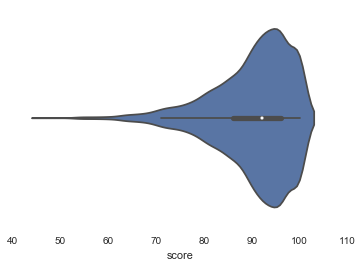

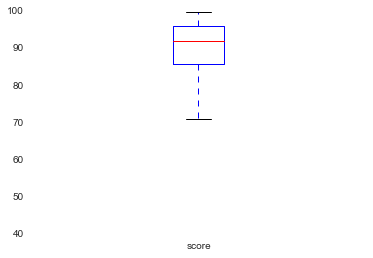

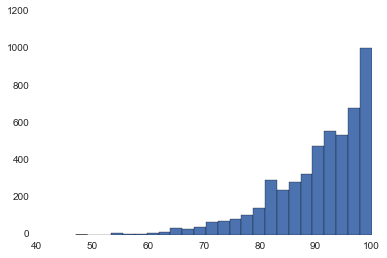

In [8]:
#1. What is the inspection score distribution like?
print "Inspection score distribution for the most recent inspection"
print
print df.score.describe()
print

#df.score.hist(bins=25)
print "Violin, boxplot, histogram plot of inspection score distribution for most recent inspection"
ax = sn.violinplot(x=df.score)
fig, ax1 = plt.subplots(1, 1)
df.boxplot('score',ax=ax1)
fig, ax2 = plt.subplots(1, 1)
df.score.hist(bins=25, ax=ax2)

In [9]:
print np.unique(df_violn.risk_category)
def transform_violation_risk(risk_cat_str):
    if str(risk_cat_str) == 'nan':
        return None
    elif risk_cat_str == 'High Risk':
        return 2
    elif risk_cat_str == 'Moderate Risk':
        return 1
    elif risk_cat_str == 'Low Risk':
        return 0

#To create a total risk score int -- this method is currently not used
def transform_list_of_tuples(violationTypeID_riskCategory_description):
    x = violationTypeID_riskCategory_description
    if str(x) == 'nan':
        return np.nan
    else:
        total_risk_score = []
        for i in range(len(x)):
            risk_cat_str = x[i][1]
            risk_score = transform_violation_risk(risk_cat_str)
            if risk_score is not None:
                total_risk_score.append(risk_score)
        total_risk_score = np.sum(total_risk_score)
        return total_risk_score

def high_risk_score(violationTypeID_riskCategory_description):
    x = violationTypeID_riskCategory_description
    if str(x) == 'nan':
        return np.nan
    else:
        counter = 0
        for i in range(len(x)):
            risk_cat_str = x[i][1]
            risk_score = transform_violation_risk(risk_cat_str)
            if risk_score is None:
                continue
            elif risk_score == 2:
                counter = counter + 1
            else:
                continue
        return counter
            
def moderate_risk_score(violationTypeID_riskCategory_description):
    x = violationTypeID_riskCategory_description
    if str(x) == 'nan':
        return np.nan
    else:
        counter = 0
        for i in range(len(x)):
            risk_cat_str = x[i][1]
            risk_score = transform_violation_risk(risk_cat_str)
            if risk_score is None:
                continue
            elif risk_score == 1:
                counter = counter + 1
            else:
                continue
        return counter

def low_risk_score(violationTypeID_riskCategory_description):
    x = violationTypeID_riskCategory_description
    if str(x) == 'nan':
        return np.nan
    else:
        counter = 0
        for i in range(len(x)):
            risk_cat_str = x[i][1]
            risk_score = transform_violation_risk(risk_cat_str)
            if risk_score is None:
                continue
            elif risk_score == 0:
                counter = counter + 1
            else:
                continue
        return counter

['High Risk' 'Low Risk' 'Moderate Risk' 'NULL']


In [10]:
#2. What is the risk category distribution like?
df['risk_scores_contain_high_risk'] = df.apply(lambda x:
     high_risk_score(x.list_of_tuples_violationTypeID_riskCategory_description), axis=1)

df['risk_scores_contain_moderate_risk'] = df.apply(lambda x:
     moderate_risk_score(x.list_of_tuples_violationTypeID_riskCategory_description), axis=1)

df['risk_scores_contain_low_risk'] = df.apply(lambda x:
     low_risk_score(x.list_of_tuples_violationTypeID_riskCategory_description), axis=1)

df['total_risk_scores'] = df.apply(lambda x: 
    np.sum([x.risk_scores_contain_high_risk,x.risk_scores_contain_moderate_risk,x.risk_scores_contain_low_risk]), axis=1)

df.head(10)

,business_id,name,address,city,postal_code,latitude,longitude,phone_number,TaxCode,business_certificate,...,owner_zip,violation_date,list_of_tuples_violationTypeID_riskCategory_description,score,inspection_date,type,risk_scores_contain_high_risk,risk_scores_contain_moderate_risk,risk_scores_contain_low_risk,total_risk_scores
0,10,Tiramisu Kitchen,033 Belden Pl,San Francisco,94104,37.791116,-122.403816,NaN,H24,779059,...,94104,20140729,"[(103144, Low Risk, Unapproved or unmaintained...",94,20140729,Routine - Unscheduled,0,1,1,2
1,17,GEORGE'S COFFEE SHOP,2200 OAKDALE Ave,S.F.,94124,37.741086,-122.401737,14155531470,H24,78443,...,94015,20140312,"[(103154, Low Risk, Unclean or degraded floors...",94,20140312,Routine - Unscheduled,0,0,3,3
2,19,Nrgize Lifestyle Cafe,"1200 Van Ness Ave, 3rd Floor",San Francisco,94109,37.786848,-122.421547,NaN,H24,NaN,...,94109,20141110,"[(103116, Moderate Risk, Inadequate food safet...",94,20141110,Routine - Unscheduled,0,1,1,2
3,24,OMNI S.F. Hotel - 2nd Floor Pantry,"500 California St, 2nd Floor",San Francisco,94104,37.792888,-122.403135,NaN,H24,352312,...,94104,20141124,"[(103119, Moderate Risk, Inadequate and inacce...",96,20141124,Routine - Unscheduled,0,1,0,1
4,45,CHARLIE'S DELI CAFE,3202 FOLSOM St,S.F.,94110,37.747114,-122.413641,NaN,H24,340024,...,94114,20140909,"[(103149, Low Risk, Wiping cloths not clean or...",94,20140909,Routine - Unscheduled,0,0,3,3
5,48,ART'S CAFE,747 IRVING St,SAN FRANCISCO,94122,37.764013,-122.465749,NaN,H24,318022,...,94122,20140523,"[(103133, Moderate Risk, Foods not protected f...",92,20140523,Routine - Unscheduled,0,1,2,3
6,50,SUSHI ZONE,1815 Market St.,SF,94103,37.771437,-122.423892,14155621114,H24,NaN,...,94112,20130328,"[(103142, Low Risk, Unclean nonfood contact su...",100,20140402,Routine - Unscheduled,0,0,2,2
7,54,RHODA GOLDMAN PLAZA,2180 POST St,S.F.,94115,37.784626,-122.437734,14155345060,H24,417778,...,94115,20140325,"[(103130, Moderate Risk, Inadequate sewage or ...",100,20150526,Routine - Unscheduled,0,2,0,2
8,56,CAFE X + O,1799 Church St,SF,94131,37.742325,-122.426476,14155823535,H24,347603,...,94131,20141117,"[(103156, Low Risk, Permit license or inspecti...",98,20141117,Routine - Unscheduled,0,0,1,1
9,58,Oasis Grill,91 Drumm St,San Francisco,94111,37.794483,-122.396584,NaN,H24,954377,...,94111,20140725,"[(103120, Moderate Risk, Moderate risk food ho...",78,20140725,Routine - Unscheduled,2,2,0,4


In [11]:
number_of_business_w_high_risk_scores = np.sum(df.risk_scores_contain_high_risk>0)
print "Number with high risk scores: %i" %(int(number_of_business_w_high_risk_scores))

number_of_business_w_moderate_risk_scores = np.sum(df.risk_scores_contain_moderate_risk>0)
print "Number with moderate risk scores: %i" %(int(number_of_business_w_moderate_risk_scores))

number_of_business_w_low_risk_scores = np.sum(df.risk_scores_contain_low_risk>0)
print "Number with low risk scores: %i" %(int(number_of_business_w_low_risk_scores))

Number with high risk scores: 1487
Number with moderate risk scores: 3352
Number with low risk scores: 3842


In [12]:
print "Risk score distribution for the most recent inspection"
print "   Number of high risk scores"
print df[(df.risk_scores_contain_high_risk>0)].risk_scores_contain_high_risk.describe()
print
print "   Number of moderate risk scores"
print df[(df.risk_scores_contain_moderate_risk>0)].risk_scores_contain_moderate_risk.describe()
print
print "   Number of low risk scores"
print df[(df.risk_scores_contain_low_risk>0)].risk_scores_contain_low_risk.describe()
print

Risk score distribution for the most recent inspection
   Number of high risk scores
count    1487.000000
mean        1.391392
std         0.692300
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         5.000000
Name: risk_scores_contain_high_risk, dtype: float64

   Number of moderate risk scores
count    3352.000000
mean        1.569212
std         0.822313
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         6.000000
Name: risk_scores_contain_moderate_risk, dtype: float64

   Number of low risk scores
count    3842.000000
mean        2.009370
std         1.201369
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         9.000000
Name: risk_scores_contain_low_risk, dtype: float64



In [13]:
#3. Which 20 businesses got lowest score?
df[(df.score.notnull())].sort(['score'], ascending=True).head(20)

,business_id,name,address,city,postal_code,latitude,longitude,phone_number,TaxCode,business_certificate,...,owner_zip,violation_date,list_of_tuples_violationTypeID_riskCategory_description,score,inspection_date,type,risk_scores_contain_high_risk,risk_scores_contain_moderate_risk,risk_scores_contain_low_risk,total_risk_scores
2024,18480,Imperial Palace,818 Washington St,San Francisco,94108,37.795138,-122.406863,NaN,H26,397410,...,94108,20141023,"[(103133, Moderate Risk, Foods not protected f...",47,20141023,Routine - Unscheduled,3,5,6,14
879,3115,Yee's Restaurant,1131 Grant Ave,San Francisco,94133,37.797292,-122.406914,NaN,H26,373352,...,94133,20140624,"[(103119, Moderate Risk, Inadequate and inacce...",53,20140624,Routine - Unscheduled,3,4,5,12
985,3459,BASIL THAI RESTAURANT & BAR,1175 FOLSOM St,S.F.,94103,37.775508,-122.409361,NaN,H26,358734,...,94103,20150407,"[(103154, Low Risk, Unclean or degraded floors...",54,20150407,Routine - Unscheduled,4,3,3,10
2143,25572,Bristol Farms #2317,845 Market St 010,SF,94103,37.784848,-122.406892,14155970106,H81,400131,...,83726,20150427,"[(103150, Low Risk, Improper or defective plum...",54,20150427,Routine - Unscheduled,4,3,3,10
1873,10102,BODEGA BISTRO,607 Larkin St,SF,94109,37.783533,-122.417603,14155921218,H26,373108,...,94109,20150914,"[(103105, High Risk, Improper cooling methods)...",54,20150914,Routine - Unscheduled,4,3,3,10
4083,74084,Miss Saigon,100 06th St,NaN,94103,NaN,NaN,NaN,H24,478180,...,94103,20141218,"[(103115, High Risk, Other high risk violation)]",54,20141217,Routine - Unscheduled,1,0,0,1
2457,36654,Evergreen Cafe,645 Clay St,San Francisco,94111,37.794543,-122.403887,NaN,H29,414085,...,94111,20151002,"[(103109, High Risk, Unclean or unsanitary foo...",54,20151002,Routine - Unscheduled,4,2,5,11
4898,82134,Harbor Villa Restaurant,5238 Diamond Heights Blvd,SF,94131,NaN,NaN,14155288883,H26,1009208,...,94122,20150428,"[(103131, Moderate Risk, Moderate risk vermin ...",55,20150427,Routine - Unscheduled,0,1,0,1
4842,81460,"Le Soleil International Holdings, Inc",133 Clement St.,NaN,94118,NaN,NaN,14155664848,H25,1013119,...,94118,20150723,"[(103139, Low Risk, Improper food storage), (1...",55,20150723,Routine - Unscheduled,3,3,6,12
2768,60469,Red Crawfish,611 Larkin St,San Francisco,94109,37.783544,-122.417603,NaN,H25,440650,...,94109,20150428,"[(103114, High Risk, High risk vermin infestat...",55,20150428,Routine - Unscheduled,5,2,1,8


In [14]:
print "The 20 lowest scoring businesses"
df[(df.score.notnull())].sort(['score','inspection_date'], ascending=[True,False]).head(20)[['name','address','inspection_date','score']]

The 20 lowest scoring businesses


,name,address,inspection_date,score
2024,Imperial Palace,818 Washington St,20141023,47
879,Yee's Restaurant,1131 Grant Ave,20140624,53
2457,Evergreen Cafe,645 Clay St,20151002,54
1873,BODEGA BISTRO,607 Larkin St,20150914,54
2143,Bristol Farms #2317,845 Market St 010,20150427,54
985,BASIL THAI RESTAURANT & BAR,1175 FOLSOM St,20150407,54
4083,Miss Saigon,100 06th St,20141217,54
4842,"Le Soleil International Holdings, Inc",133 Clement St.,20150723,55
2768,Red Crawfish,611 Larkin St,20150428,55
4898,Harbor Villa Restaurant,5238 Diamond Heights Blvd,20150427,55


In [15]:
#4. Which 20 businesses got highest score?
print "Number of businesses with score of 100: %i" %(len(list(df[(df.score==100)].score)))
print "The 20 of the highest scoring businesses (score=100)"
df[(df.score.notnull())].sort(['score','inspection_date'], ascending=[False,False]).head(20)[['name','address','inspection_date','score']]

Number of businesses with score of 100: 625
The 20 of the highest scoring businesses (score=100)


,name,address,inspection_date,score
3592,Moolicious Cafe and Crepe,1 Sansome St #105,20151130,100
485,Cafe Venue,218 Montgomery St,20151124,100
1023,Lee's Deli,235 Montgomery St,20151124,100
2732,Manhattan Hub Inc,343 Sansome St Suite 140,20151120,100
1302,Starbucks Coffee,398 Market St,20151118,100
3795,Chipotle Mexican Grill #1857,211 Sutter St,20151118,100
1179,Barbarossa,714 Montgomery St,20151117,100
3511,Walgreens #5618,100 Sansome St,20151117,100
2379,Cornerstone Academy,501 Cambridge St,20151116,100
811,Leatherneck Steakhouse - Marines' Memorial Assn,"609 Sutter St, 12th Floor",20151113,100


In [16]:
#5. Among all the restaurants that got 100 score, what kind of violations did they get (if any)?
print "Number of restaurants that got score 100: %i" %(df[(df.score==100)].shape[0])
print
tuple_list = list(df[(df.score==100)].list_of_tuples_violationTypeID_riskCategory_description)
risk_scores = list(np.unique([tup[0][1].upper() for tup in tuple_list if str(tup)!='nan']))
print "Risk scores among restaurants that got score 100:"
for risk in risk_scores:
    print "    "+risk
print
risk_descriptions = list(np.unique([tup[0][2].upper() for tup in tuple_list if str(tup)!='nan']))
print "Descriptions of risk scores among restaurants that got score 100:"
for descr in risk_descriptions:
    print "    "+descr

Number of restaurants that got score 100: 625

Risk scores among restaurants that got score 100:
    HIGH RISK
    LOW RISK
    MODERATE RISK

Descriptions of risk scores among restaurants that got score 100:
    CONTAMINATED OR ADULTERATED FOOD
    FOOD IN POOR CONDITION
    FOOD SAFETY CERTIFICATE OR FOOD HANDLER CARD NOT AVAILABLE
    FOODS NOT PROTECTED FROM CONTAMINATION
    HIGH RISK FOOD HOLDING TEMPERATURE 
    HIGH RISK VERMIN INFESTATION
    IMPROPER COOKING TIME OR TEMPERATURES
    IMPROPER COOLING METHODS
    IMPROPER FOOD LABELING OR MENU MISREPRESENTATION
    IMPROPER FOOD STORAGE
    IMPROPER OR DEFECTIVE PLUMBING
    IMPROPER REHEATING OF FOOD
    IMPROPER STORAGE OF EQUIPMENT UTENSILS OR LINENS
    IMPROPER STORAGE USE OR IDENTIFICATION OF TOXIC SUBSTANCES
    IMPROPER THAWING METHODS 
    INADEQUATE AND INACCESSIBLE HANDWASHING FACILITIES
    INADEQUATE DRESSING ROOMS OR IMPROPER STORAGE OF PERSONAL ITEMS
    INADEQUATE FOOD SAFETY KNOWLEDGE OR LACK OF CERTIFIED FOOD 

In [17]:
#6. Average inspection score by zip code
byZip_averageScore = pd.DataFrame(df[(df.score.notnull())].groupby('postal_code').apply(lambda x: np.mean(x.score)),
             columns = ['Average Score'])
byZip_averageScore

,Average Score
postal_code,
92672,88.000000
94013,98.000000
94014,60.000000
94101,100.000000
94102,90.714286
94103,89.295872
94104,93.058252
94105,89.883041
94107,93.264535


In [18]:
# Average inspection score by zip code showing Number of Restaurants
byZip_nRestaurants = pd.DataFrame(df[(df.score.notnull())].groupby('postal_code').apply(lambda x: np.size(x.score)),
             columns = ['Number of Restaurants'])
byZip = byZip_averageScore.join(byZip_nRestaurants)
byZip

,Average Score,Number of Restaurants
postal_code,,
92672,88.000000,1
94013,98.000000,2
94014,60.000000,1
94101,100.000000,1
94102,90.714286,378
94103,89.295872,436
94104,93.058252,103
94105,89.883041,171
94107,93.264535,344


In [19]:
def found_items_in_list(list_of_tuples_violationTypeID_riskCategory_description,search_list):
    tuple_list = list_of_tuples_violationTypeID_riskCategory_description
    if str(tuple_list) == 'nan':
        return np.nan
    else:
        risk_descriptions = list(np.unique([tup[2].upper() for tup in tuple_list if str(tup[2])!='nan']))
        if len(set(risk_descriptions) & set(search_list)) > 0:
            return True
        else:
            return False

In [20]:
#7.Compute the proportion of all businesses in each neighborhood that have incurred at least one of the violations 
#  on this list:
#    "High risk vermin infestation"
#    "Moderate risk vermin infestation"
#    "Sewage or wastewater contamination”
#    "Improper food labeling or menu misrepresentation"
#    "Contaminated or adulterated food”
#    "Reservice of previously served foods"

search_list = ["High risk vermin infestation",
               "Moderate risk vermin infestation",
               "Sewage or wastewater contamination",
               "Improper food labeling or menu misrepresentation",
               "Contaminated or adulterated food",
               "Reservice of previously served foods"]
search_list = [nm.upper() for nm in search_list]

df['business_w_violations_in_list'] = df.apply(lambda x: 
         found_items_in_list(x.list_of_tuples_violationTypeID_riskCategory_description,search_list),axis=1)

byZip_violations_in_list = pd.DataFrame(df[(df.business_w_violations_in_list.notnull())].groupby('postal_code').apply(lambda x: 
        np.sum(x.business_w_violations_in_list)/float(np.size(x.business_id))), columns = ['proportion_of_business_w_violations_in_list'])
byZip_violations_in_list

,proportion_of_business_w_violations_in_list
postal_code,
92672,0.000000
94013,0.000000
94014,0.000000
94101,0.000000
94102,0.190476
94103,0.172018
94104,0.097087
94105,0.076023
94107,0.093023


In [21]:
byZip = byZip.join(byZip_violations_in_list)
byZip

,Average Score,Number of Restaurants,proportion_of_business_w_violations_in_list
postal_code,,,
92672,88.000000,1,0.000000
94013,98.000000,2,0.000000
94014,60.000000,1,0.000000
94101,100.000000,1,0.000000
94102,90.714286,378,0.190476
94103,89.295872,436,0.172018
94104,93.058252,103,0.097087
94105,89.883041,171,0.076023
94107,93.264535,344,0.093023
